## Полносвязная нейронная сеть с нуля

##### Автор: Андрей Гришин

> ### Подготовка данных


Dataset: MNIST from PyTorch

In [96]:
import numpy as np

from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision.datasets import MNIST

from tqdm.auto import tqdm

In [97]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_mnist_data.data = train_mnist_data.data.reshape(60000, 784)
test_mnist_data.data = test_mnist_data.data.reshape(10000, 784)

train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

> ### Написание класса нейросети
*   Построение архитектуры
*   Написание алгоритма




In [104]:
class SimpleDL():
  def __init__(self):
    self.num_input_layer = 784
    self.num_hidden_layers = 3
    self.num_neurons_on_layer = 100
    self.num_output_layer = 10
    self.batch_size = 32
    self.num_epochs = 20
    self.learning_rate = 0.01
    '''
    # self.weights_first = np.array([[]])     # матрица ('нейроны справа' х 'нейроны слева') 3х784
    # self.weights_hidden = np.array([[[]]])    # тензор ('межслои' х 'нейроны справа' х 'нейроны слева') 0х3х3
    # self.weights_last = np.array([[]])      # матрица ('нейроны справа' х 'нейроны слева') 10х3

    # self.bias_first = np.array([[]])     # матрица-строка ('нейроны справа') 1х3
    # self.bias_hidden = np.array([[]])    # матрица ('межслои' х 'нейроны справа') 0х3
    # self.bias_last = np.array([[]])      # матрица-строка ('нейроны справа') 1х10

    # self.input_hidden = np.array([[[]]])    # тензор ndim=3 ('слои' х 'объекты' х 'нейроны справа') 0х32х3
    # self.input_last = np.array([[]])      # матрица ('объекты' х 'нейроны справа') 32х10

    # self.output_first = np.array([[]])     # матрица ('объекты' х 'нейроны слева') 32х784
    # self.output_hidden = np.array([[[]]])    # тензор ndim=3 ('слои' х 'объекты' х 'нейроны слева') 0х32х3

    # self.gradient_weights_last = np.array([[]])    # матрица ('нейроны слева' х 'нейроны справа') 3х10
    # self.gradient_bias_last = np.array([[]])       # матрица ('объекты' х 'нейроны справа') 32х10

    # self.gradient_weights_hidden = np.array([[[]]])    # тензор ndim=3 ('межслои' х 'нейроны слева' х 'нейроны справа') 0х3х3
    # self.gradient_bias_hidden = np.array([[[]]])        # тензор ndim=3 ('межслои' х 'объекты' х 'нейроны справа') 0х32х3

    # self.gradient_weights_first = np.array([[]])    # матрица ('нейроны слева' х 'нейроны справа') 784х3
    # self.gradient_bias_first = np.array([[]])       # матрица ('объекты' х 'нейроны справа') 32х3
    '''
    return

  def linear(self, x, W, b):
    linear_funtion = x @ W.T + b
    return linear_funtion

  def relu(self, input):
    neurons_output = np.maximum(input, 0)
    max_out = np.max(neurons_output, axis=1, keepdims=True)
    max_out[max_out == 0] = 1
    neurons_output_norm = neurons_output / max_out
    return neurons_output_norm

  def gradient_relu(self, input):
    gradient = (input > 0).astype(float)
    return gradient

  def softmax(self, input):
    input_exp = np.exp(input)
    sum_exp = np.expand_dims(np.sum(input_exp, axis=1), axis=0).T
    neurons_output = input_exp / sum_exp
    return neurons_output

  def loss_function(self, targets):
    predictions_matrix = self.softmax(self.input_last)
    target_predictions = predictions_matrix[np.arange(self.batch_size), targets]
    error = -np.sum(np.log(target_predictions))
    return error

  def forward_pass(self, data):
    self.input_hidden = np.expand_dims(self.linear(data, self.weights_first, self.bias_first), axis=0)
    self.output_hidden = np.expand_dims(self.relu(self.input_hidden[0]), axis=0)

    for step in range(self.hidden_steps):
      self.input_hidden = np.append(self.input_hidden, np.expand_dims(self.linear(self.output_hidden[step], self.weights_hidden[step], self.bias_hidden[step]), axis=0), axis=0)
      self.output_hidden = np.append(self.output_hidden, np.expand_dims(self.relu(self.input_hidden[step + 1]), axis=0), axis=0)

    self.input_last = self.linear(self.output_hidden[-1], self.weights_last, self.bias_last)
    return

  def backprop(self, targets, steps):
    predictions_matrix = self.softmax(self.input_last)
    targets_matrix = np.zeros([self.batch_size, self.num_output_layer])
    targets_matrix[np.arange(self.batch_size), targets] = 1

    d_last_layer = predictions_matrix - targets_matrix
    d_last_linear = d_last_layer @ self.weights_last
    self.gradient_weights_last = self.output_hidden[-1].T @ d_last_layer
    self.gradient_bias_last = d_last_layer

    d_linear = d_last_linear
    for step in range(steps):
      d_activation = d_linear * self.gradient_relu(self.input_hidden[-(step + 1)])
      d_linear = d_activation @ self.weights_hidden[-(step + 1)]
      d_weights = self.output_hidden[-(step + 2)].T @ d_activation
      d_bias = d_activation
      if step == 0:
        self.gradient_weights_hidden = np.expand_dims(d_weights, axis=0)
        self.gradient_bias_hidden = np.expand_dims(d_bias, axis=0)
      else:
        self.gradient_weights_hidden = np.append(self.gradient_weights_hidden, np.expand_dims(d_weights, axis=0), axis=0)
        self.gradient_bias_hidden = np.append(self.gradient_bias_hidden, np.expand_dims(d_bias, axis=0), axis=0)

    d_first_activation = d_linear * self.gradient_relu(self.input_hidden[0])
    self.gradient_weights_first = self.output_first.T @ d_first_activation
    self.gradient_bias_first = d_first_activation
    return

  def update(self, learning_rate):
    self.weights_first = self.weights_first - learning_rate * self.gradient_weights_first.T
    self.bias_first = self.bias_first - learning_rate * np.sum(self.gradient_bias_first, axis=0)

    for step in range(self.num_hidden_layers - 1):
      self.weights_hidden[step] = self.weights_hidden[step] - learning_rate * self.gradient_weights_hidden[-(step + 1)].T
      self.bias_hidden[step] = self.bias_hidden[step] - learning_rate * np.sum(self.gradient_bias_hidden[-(step + 1)], axis=0)

    self.weights_last = self.weights_last - learning_rate * self.gradient_weights_last.T
    self.bias_last = self.bias_last - learning_rate * np.sum(self.gradient_bias_last, axis=0)
    return

  def fit(self):
    self.hidden_steps = self.num_hidden_layers - 1
    self.weights_first = np.random.randn(self.num_neurons_on_layer, self.num_input_layer)
    self.bias_first = np.expand_dims(np.random.randn(self.num_neurons_on_layer), axis=0)

    for step in range(self.hidden_steps):
      if step == 0:
        self.weights_hidden = np.expand_dims(np.random.randn(self.num_neurons_on_layer, self.num_neurons_on_layer), axis=0)
        self.bias_hidden = np.expand_dims(np.random.randn(self.num_neurons_on_layer), axis=0)
      else:
        self.weights_hidden = np.append(self.weights_hidden, np.expand_dims(np.random.randn(self.num_neurons_on_layer, self.num_neurons_on_layer), axis=0), axis=0)
        self.bias_hidden = np.append(self.bias_hidden, np.expand_dims(np.random.randn(self.num_neurons_on_layer), axis=0), axis=0)

    self.weights_last = np.random.randn(self.num_output_layer, self.num_neurons_on_layer)
    self.bias_last = np.expand_dims(np.random.randn(self.num_output_layer), axis=0)

    self.loss_list = list()
    for epoch in tqdm(range(self.num_epochs)):
      loss = 0
      for batch in train_data_loader:
        self.output_first = batch[0].numpy().squeeze()
        targets = batch[1].numpy()

        self.forward_pass(self.output_first)
        self.backprop(targets, self.hidden_steps)
        self.update(self.learning_rate)

        loss += self.loss_function(targets)
      self.loss_list.append(loss)
      if epoch % (self.num_epochs / 10) == 0:
        print(f'Epoch: {epoch}', '\n', f'Loss: {loss}')
        print('-------------------------------------------------------------------------')
    print(f'Actual loss is {loss}')
    return

  def predict(self, data):
    self.forward_pass(data)
    predictions = self.softmax(self.input_last)
    return predictions

> ### Настройка гиперпараметров



In [105]:
classifier = SimpleDL()
classifier.num_input_layer = 784
classifier.num_hidden_layers = 3
classifier.num_neurons_on_layer = 100
classifier.num_output_layer = 10
classifier.batch_size = 32
classifier.num_epochs = 200
classifier.learning_rate = 0.01

> ### Обучение нейросети



In [106]:
classifier.fit()

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 
 Loss: 29441.076487583556
-------------------------------------------------------------------------
Epoch: 20 
 Loss: 5915.00272970576
-------------------------------------------------------------------------
Epoch: 40 
 Loss: 4173.86301210069
-------------------------------------------------------------------------
Epoch: 60 
 Loss: 3153.410403054957
-------------------------------------------------------------------------
Epoch: 80 
 Loss: 2446.482182764871
-------------------------------------------------------------------------
Epoch: 100 
 Loss: 2071.114682467285
-------------------------------------------------------------------------
Epoch: 120 
 Loss: 1670.2015481548447
-------------------------------------------------------------------------
Epoch: 140 
 Loss: 1383.3024771132723
-------------------------------------------------------------------------
Epoch: 160 
 Loss: 1150.358129855827
-------------------------------------------------------------------------
Epoch:

> ### Визуализация изменения ошибки с каждой эпохой

Text(0.5, 1.0, 'Loss value per epoch')

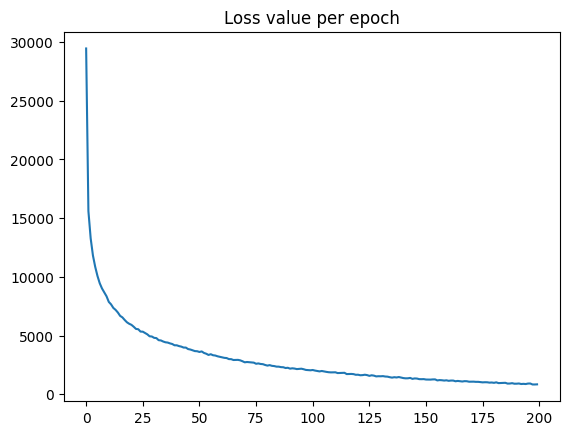

In [107]:
plt.plot(classifier.loss_list)
plt.title(f'Loss value per epoch')

> ### Оценка точности предсказаний



In [109]:
num_test_objects = len(test_mnist_data.targets)
miss_count = 0
for batch in tqdm(test_data_loader):
  data = batch[0].numpy().squeeze()
  targets = batch[1].numpy()
  predictions_matrix = classifier.predict(data)
  predictions = np.argmax(predictions_matrix, axis=1)
  miss_count += np.sum((targets != predictions).astype(float))
print(f'Accuracy: {(num_test_objects - miss_count) / num_test_objects}')

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9705
